In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [98]:
import requests

# Adjust date_from and date_to parameters for a more recent time frame
url = "https://api.openaq.org/v2/measurements?date_from=2024-03-01T00%3A00%3A00%2B00%3A00&date_to=2024-04-09T00%3A00%3A00%2B00%3A00&limit=10000&page=1&offset=0&sort=desc&radius=1000&location_id=2498781&order_by=datetime"

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    results = data['results']
    rows = []
    for result in results:
        location = result['location']
        parameter = result['parameter']
        value = result['value']
        lastUpdated = result['date']['local']  # Use local date for lastUpdated

        rows.append({
            'location': location,
            'parameter': parameter,
            'value': value,
            'lastUpdated': lastUpdated
        })
    df = pd.DataFrame(rows)
else:
    print(f"Error: {response.status_code} - {response.text}")

In [99]:
df = df.drop(['location'], axis = 1)
df

,parameter,value,lastUpdated
0,temperature,26.597366,2024-04-09T05:30:00+05:30
1,temperature,26.771473,2024-04-09T04:30:00+05:30
2,temperature,26.803690,2024-04-09T03:30:00+05:30
3,temperature,27.283244,2024-04-09T02:30:00+05:30
4,temperature,28.031577,2024-04-09T01:30:00+05:30
...,...,...,...
3453,pm1,31.299107,2024-03-08T09:30:00+05:30
3454,pm1,41.995535,2024-03-08T08:30:00+05:30
3455,pm1,52.781250,2024-03-08T07:30:00+05:30
3456,pm1,37.860120,2024-03-08T06:30:00+05:30


In [100]:
df['lastUpdated'] = pd.to_datetime(df.lastUpdated)

In [101]:
df.dtypes

parameter                         object
value                            float64
lastUpdated    datetime64[ns, UTC+05:30]
dtype: object

In [102]:
df_agg = df.groupby(['lastUpdated', 'parameter']).agg({'value': 'mean'}).unstack()

df_agg.columns = df_agg.columns.droplevel()

df_agg.reset_index(inplace=True)

df_agg

parameter,lastUpdated,pm1,pm10,pm25,relativehumidity,temperature,um003
0,2024-03-01 22:30:00+05:30,NaN,NaN,47.595238,NaN,28.202689,NaN
1,2024-03-01 23:30:00+05:30,NaN,NaN,46.930195,NaN,28.171331,NaN
2,2024-03-02 00:30:00+05:30,NaN,NaN,45.644346,NaN,28.289092,NaN
3,2024-03-02 01:30:00+05:30,NaN,NaN,45.983631,NaN,28.220551,NaN
4,2024-03-02 03:30:00+05:30,NaN,NaN,43.107142,NaN,28.111979,NaN
...,...,...,...,...,...,...,...
637,2024-04-09 01:30:00+05:30,26.305060,50.473214,41.784226,27.890610,28.031577,5914.903239
638,2024-04-09 02:30:00+05:30,22.206845,42.227679,35.614584,24.421905,27.283244,4593.638387
639,2024-04-09 03:30:00+05:30,21.938988,42.364584,35.578869,27.217128,26.803690,4517.233643
640,2024-04-09 04:30:00+05:30,23.197917,44.630953,37.355654,30.050937,26.771473,4895.416667


In [103]:
df = df_agg.dropna()
df.isna().sum()

parameter
lastUpdated         0
pm1                 0
pm10                0
pm25                0
relativehumidity    0
temperature         0
um003               0
dtype: int64

In [104]:
df = df.set_index('lastUpdated')
df

parameter,pm1,pm10,pm25,relativehumidity,temperature,um003
lastUpdated,,,,,,
2024-03-07 05:30:00+05:30,32.000000,63.142857,51.000000,35.166845,25.938572,8558.563965
2024-03-07 06:30:00+05:30,32.428570,65.428574,52.285713,37.052009,25.891428,8883.061035
2024-03-07 07:30:00+05:30,36.571430,70.285713,59.428570,39.215565,25.575714,9448.223145
2024-03-07 08:30:00+05:30,44.571430,78.428574,73.285713,39.381354,25.562857,9849.007487
2024-03-07 09:30:00+05:30,30.250000,60.625000,48.625000,37.774037,26.059999,7869.144857
...,...,...,...,...,...,...
2024-04-09 01:30:00+05:30,26.305060,50.473214,41.784226,27.890610,28.031577,5914.903239
2024-04-09 02:30:00+05:30,22.206845,42.227679,35.614584,24.421905,27.283244,4593.638387
2024-04-09 03:30:00+05:30,21.938988,42.364584,35.578869,27.217128,26.803690,4517.233643


<Axes: xlabel='parameter', ylabel='parameter'>

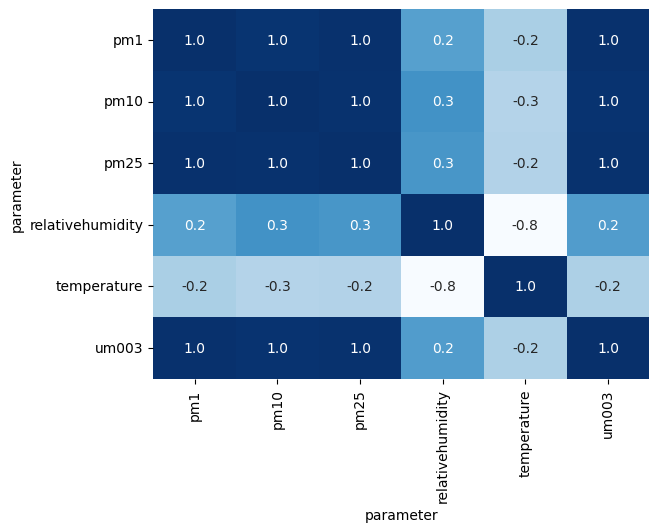

In [105]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

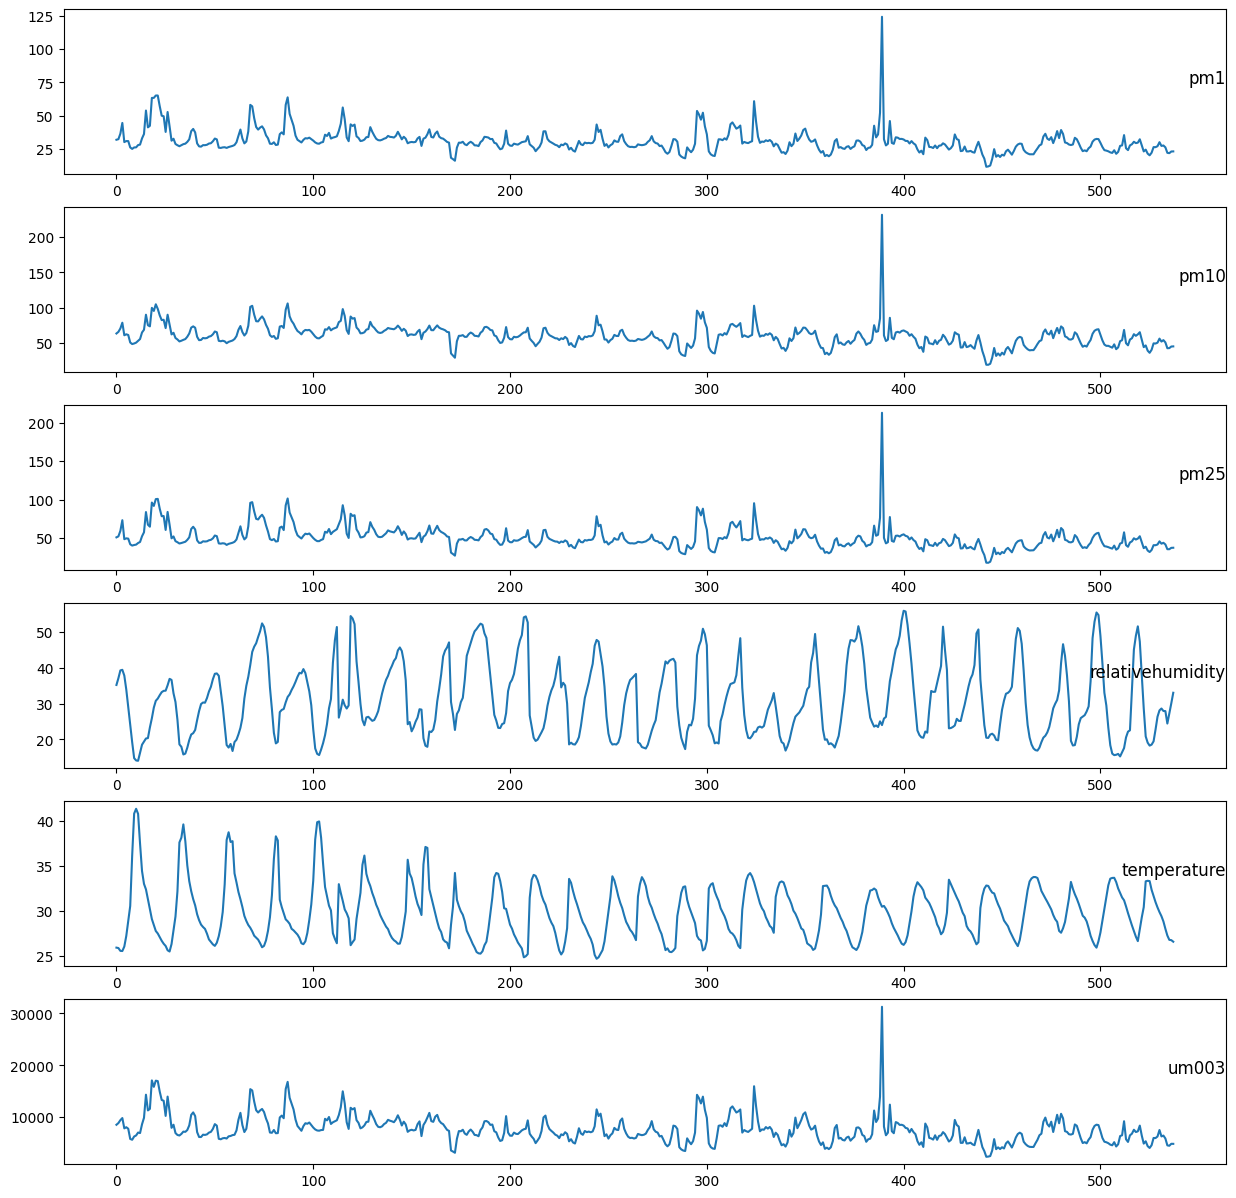

In [106]:
from matplotlib import pyplot
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3,4, 5]
i = 1
# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 538 entries, 2024-03-07 05:30:00+05:30 to 2024-04-09 05:30:00+05:30
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pm1               538 non-null    float64
 1   pm10              538 non-null    float64
 2   pm25              538 non-null    float64
 3   relativehumidity  538 non-null    float64
 4   temperature       538 non-null    float64
 5   um003             538 non-null    float64
dtypes: float64(6)
memory usage: 29.4 KB


In [108]:
538*0.7

376.59999999999997

In [125]:
train_df,test_df = df[1:376], df[376:]

In [126]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [127]:
import joblib

# Save a variable to a file
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [128]:
def split_series(series, n_past, n_future):

  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [129]:
n_past = 10
n_future = 3
n_features = 6

In [130]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [131]:
# E1D1

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 10, 6)]              0         []                            
                                                                                                  
 lstm_24 (LSTM)              [(None, 100),                42800     ['input_9[0][0]']             
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 repeat_vector_8 (RepeatVec  (None, 3, 100)               0         ['lstm_24[0][0]']             
 tor)                                                                                       

In [132]:
# E2D2

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 10, 6)]              0         []                            
                                                                                                  
 lstm_26 (LSTM)              [(None, 10, 100),            42800     ['input_10[0][0]']            
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 lstm_27 (LSTM)              [(None, 100),                80400     ['lstm_26[0][0]']             
                              (None, 100),                                                  

In [133]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [139]:
X_test[0].shape

(10, 6)

In [134]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

5/5 [==============================] - 3s 11ms/step


In [135]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [136]:
print(X_test[-1])
print()
print(y_test[-1])
print()
print(pred_e1d1[-1])
print()
print(pred_e2d2[-1])


[[-0.83322673 -0.81976867 -0.87321038 -0.79031822  0.03569606 -0.86715048]
 [-0.75465205 -0.7067717  -0.80160588 -0.7767425  -0.08057164 -0.7900115 ]
 [-0.58233592 -0.47205005 -0.63424842 -0.73136835 -0.16482671 -0.59112501]
 [-0.58385868 -0.47730213 -0.63512946 -0.56803238 -0.24506798 -0.59350455]
 [-0.55425612 -0.44609858 -0.61030014 -0.3903936  -0.31531033 -0.54981745]
 [-0.4312776  -0.29641429 -0.50089104 -0.30369373 -0.3775964  -0.37143922]
 [-0.54578955 -0.40497016 -0.58182655 -0.2775405  -0.43198868 -0.54817229]
 [-0.53251104 -0.35171561 -0.55103021 -0.31188514 -0.5021239  -0.52482432]
 [-0.58952337 -0.43594199 -0.60825775 -0.31331934 -0.600265   -0.60551925]
 [-0.75727121 -0.64992565 -0.77429365 -0.48555382 -0.69005516 -0.79512399]]

[[  21.93898821   42.36458365   35.57886918   27.21712796   26.80369043
  4517.23364258]
 [  23.19791667   44.63095252   37.35565408   30.05093749   26.77147309
  4895.41666667]
 [  23.26785723   44.80952358   37.48511918   32.99480629   26.5973658

In [137]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,4):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

pm1
Day  1 :
MAE-E1D1 :  4.414105713632371, MAE-E2D2 :  4.823082692358229
Day  2 :
MAE-E1D1 :  5.156793506940204, MAE-E2D2 :  5.267528480423821
Day  3 :
MAE-E1D1 :  5.898180859353806, MAE-E2D2 :  6.181425363222758


pm10
Day  1 :
MAE-E1D1 :  8.96748454782698, MAE-E2D2 :  9.227074323760137
Day  2 :
MAE-E1D1 :  10.367535065015158, MAE-E2D2 :  10.085430297321745
Day  3 :
MAE-E1D1 :  11.660978988541498, MAE-E2D2 :  11.853861178821989


pm25
Day  1 :
MAE-E1D1 :  7.15308269182841, MAE-E2D2 :  7.646795265409681
Day  2 :
MAE-E1D1 :  8.76325490421719, MAE-E2D2 :  8.693317054112752
Day  3 :
MAE-E1D1 :  10.125950256983439, MAE-E2D2 :  10.490491522683035


relativehumidity
Day  1 :
MAE-E1D1 :  3.5526372098922736, MAE-E2D2 :  4.088607796033224
Day  2 :
MAE-E1D1 :  5.4463403262032415, MAE-E2D2 :  5.436043631765577
Day  3 :
MAE-E1D1 :  7.239552703963384, MAE-E2D2 :  7.051459730466207


temperature
Day  1 :
MAE-E1D1 :  0.8970610756344267, MAE-E2D2 :  0.9850658278995092
Day  2 :
MAE-E1D1 :  1.195985803

In [43]:
model_e2d2.save('model.h5')